<a href="https://colab.research.google.com/github/hyelimchoi1223/wanted_pre_onboarding_project/blob/main/assignment/4%ED%8C%80_%EC%B5%9C%ED%98%9C%EB%A6%BC_Week2_3_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week2_3 Assignment

## [BASIC](#Basic) 
- **Custom Dataset 클래스를 구현**할 수 있다.
- train_dataset, valid_dataset으로 데이터셋을 나눌 수 있다.


## [CHALLENGE](#Challenge)
- **dynamic padding**을 만드는 `collate_fn`을 구현할 수 있다. 
- `DataLoader` 클래스를 사용해 **train_dataloaer와 valid_dataloader**를 만들 수 있다.


## [ADVANCED](#Advanced)
- 기존 코드의 data_iterator를 **data_loader로 대체**해 학습을 실행할 수 있다.

### Reference
-[DataLoader pytorch official document](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)   
-[collate_fn 설명 영문 블로그](https://androidkt.com/create-dataloader-with-collate_fn-for-variable-length-input-in-pytorch/)   
-[dynamic padding 설명 영문 블로그](https://mccormickml.com/2020/07/29/smart-batching-tutorial/#dynamic-padding)   


In [ ]:
import os
import sys
import pandas as pd
import numpy as np 
import torch
import random

In [ ]:
# seed
seed = 7777
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [ ]:
# device type
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"# available GPUs : {torch.cuda.device_count()}")
    print(f"GPU name : {torch.cuda.get_device_name()}")
else:
    device = torch.device("cpu")
print(device)

# available GPUs : 1
GPU name : Tesla T4
cuda


## Basic

### 데이터 로드 및 결측치 제거 (복습)
- 해당 링크에서 `sample_df` 데이터 프레임을 로드하자
  - df의 개수는 10,000개이다.

In [ ]:
!wget https://raw.githubusercontent.com/ChristinaROK/PreOnboarding_AI_assets/e56006adfac42f8a2975db0ebbe60eacbe1c6b11/data/sample_df.csv

--2022-03-02 04:27:04--  https://raw.githubusercontent.com/ChristinaROK/PreOnboarding_AI_assets/e56006adfac42f8a2975db0ebbe60eacbe1c6b11/data/sample_df.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 971625 (949K) [text/plain]
Saving to: ‘sample_df.csv’

sample_df.csv       100%[===================>] 948.85K  --.-KB/s    in 0.01s   

2022-03-02 04:27:04 (96.4 MB/s) - ‘sample_df.csv’ saved [971625/971625]



In [ ]:
sample_df = pd.read_csv('sample_df.csv')

In [ ]:
sample_df = sample_df.dropna(axis=0, how='any')

In [ ]:
sample_df.isnull().sum()

id          0
document    0
label       0
dtype: int64

In [ ]:
print(f"Shape: {sample_df.shape}\nLabel : {sample_df.label.value_counts()}")

Shape: (10000, 3)
Label : 0    5000
1    5000
Name: label, dtype: int64


### `CustomDataset `클래스 구현
- 클래스 정의
  - 생성자 입력 매개변수 
    - `input_data` : 리뷰 텍스트 리스트
    - `target_data` : 레이블 (0 또는 1) list
  - 생성자에서 생성할 변수
    - `X` : `input_data`
    - `Y` : `target_data`
  - 메소드 
    - `__len__()`
      - 데이터 총 개수를 반환
    - `__getitem__()`
      - 해당 인덱스의 (input_data, target_data) 튜플을 반환
  - 주의 사항
    - `torch.utils.data.Dataset()` 클래스를 부모 클래스로 상속받아 구현한다.  

In [ ]:
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler, random_split

In [ ]:
class CustomDataset(Dataset):
  """
  - input_data: list of string
  - target_data: list of int
  """

  def __init__(self, input_data:list, target_data:list) -> None:
      self.X = input_data
      self.Y = target_data

  def __len__(self):
      return len(self.Y)

  def __getitem__(self, index):
      return self.X[index], self.Y[index]

In [ ]:
dataset = CustomDataset(sample_df.document.tolist(), sample_df.label.tolist())

In [ ]:
dataset[0]

('나 이거 더빙을 누가하는지 모르고 봤는데 왠지 더빙이 구리더라...더빙이 너무 별로였음.', 0)

In [ ]:
# 데이터 셋 총 개수 확인 가능
len(dataset)

10000

###  `torch.utils.data.random_split` 함수를 사용해 데이터셋을 train, valid로 분리
- 데이터 비율은 `train : valid = 9 : 1`으로 분리하라

In [ ]:
n_train = len(dataset) // 10 * 9
n_valid = len(dataset) // 10 * 1

In [ ]:
train_dataset, valid_dataset = random_split(dataset, [n_train, n_valid])

In [ ]:
len(train_dataset)

9000

In [ ]:
len(valid_dataset)

1000

## Challenge

### dynamic padding을 구현하는  `custom_collate_fn` 함수 구현 
- batch (`List[Tuple(input, target)]`)를 입력받아 토크나이즈한 후 텐서 형태로 변형해 반환 ( `Tuple(Tensor(tokenized_input), Tensor(target))`)하는 `collate_fn()` 함수를 구현하라. 
- 함수 정의
  - 입력 매개변수
    - `batch` : (input(string), target(int)) 튜플을 담고 있는 리스트.  만약 `batch_size`가 32라면 리스트는 32개의 튜플을 갖고 있다. 
  - 조건
    - input
      - [BERT Tokenizer](https://huggingface.co/docs/transformers/main_classes/tokenizer#transformers.PreTrainedTokenizer) 클래스의 `__call__()` 메소드 사용 방법을 읽고, `__call__()` 파라미터를 조정해 dynamic padding을 구현한다.
      - 토크나이즈할 때 한 배치내 인풋들의 토큰 개수는 모두 동일할 수 있도록하라. 이때, 가장 긴 토큰을 가지고 있는 인풋을 기준으로 토큰 개수를 맞춘다. 즉, 토큰 개수가 모자란 인풋은 `[PAD]` 토큰을 추가한다. (이를 **dynamic padding**이라고 한다.) 
      - 토크나이저에서 반환된 값은 Tensor 타입이어야 한다. 
    - target
      - target은 Tensor 타입으로 변형한다.
  - 반환값
    - (tensorized_input, tensorized_label) 튜플

In [ ]:
!pip install transformers

In [ ]:
from transformers import BertTokenizer, BertModel

In [ ]:
tokenizer_bert = BertTokenizer.from_pretrained("klue/bert-base")

In [ ]:
def custom_collate_fn(batch):
    """
    - batch: list of tuples (input_data(string), target_data(int))
    
    한 배치 내 문장들을 tokenizing 한 후 텐서로 변환함. 
    이때, dynamic padding (즉, 같은 배치 내 토큰의 개수가 동일할 수 있도록, 부족한 문장에 [PAD] 토큰을 추가하는 작업)을 적용
    토큰 개수는 배치 내 가장 긴 문장으로 해야함.
    또한 최대 길이를 넘는 문장은 최대 길이 이후의 토큰을 제거하도록 해야 함
    토크나이즈된 결과 값은 텐서 형태로 반환하도록 해야 함
    
    한 배치 내 레이블(target)은 텐서화 함.
    
    (input, target) 튜플 형태를 반환.
    """
    global tokenizer_bert
    input_list, target_list = [], []
    for input, target in batch:
        input_list.append(input)
        target_list.append(target)

    tensorized_input = tokenizer_bert(input_list,
                                        add_special_tokens=True,
                                        return_tensors='pt',
                                        padding="longest",
                                        truncation=True)
                                        
    
    tensorized_label = torch.tensor(target_list)
    return tensorized_input, tensorized_label
    

### 위에서 구현한 `custom_collate_fn`함수를 적용해 DataLoader 인스턴스 생성
- `train_dataloader`
    - batch_size = 32
    - collate_fn = 위에서 구현한 함수
    - sampler = `RandomSampler()`
        - `train_dataset`의 학습 데이터를 셔플링 함
- `valid_dataloader`
    - batch_size = 64
    - collate_fn = 위에서 구현한 함수
    - sampler = `SequentialSampler()`
        - `valid_dataset`의 검증 데이터를 순차적으로 정렬함 (셔플X)

In [ ]:
train_sampler = RandomSampler(train_dataset)
valid_sample = SequentialSampler(valid_dataset)

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=32,sampler=train_sampler, collate_fn=custom_collate_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=64, sampler=valid_sample, collate_fn=custom_collate_fn)

In [ ]:
# 배치마다 토큰 길이가 다른 것을 확인
for idx, (input_batch, target_batch) in enumerate(train_dataloader):
    print(f"Batch input shape: {input_batch['input_ids'].shape}")
    print(f"Batch target shape: {target_batch.shape}")

Batch input shape: torch.Size([32, 97])
Batch target shape: torch.Size([32])
Batch input shape: torch.Size([32, 78])
Batch target shape: torch.Size([32])
Batch input shape: torch.Size([32, 74])
Batch target shape: torch.Size([32])
Batch input shape: torch.Size([32, 75])
Batch target shape: torch.Size([32])
Batch input shape: torch.Size([32, 74])
Batch target shape: torch.Size([32])
Batch input shape: torch.Size([32, 74])
Batch target shape: torch.Size([32])
Batch input shape: torch.Size([32, 45])
Batch target shape: torch.Size([32])
Batch input shape: torch.Size([32, 66])
Batch target shape: torch.Size([32])
Batch input shape: torch.Size([32, 79])
Batch target shape: torch.Size([32])
Batch input shape: torch.Size([32, 86])
Batch target shape: torch.Size([32])
Batch input shape: torch.Size([32, 74])
Batch target shape: torch.Size([32])
Batch input shape: torch.Size([32, 78])
Batch target shape: torch.Size([32])
Batch input shape: torch.Size([32, 47])
Batch target shape: torch.Size([32])

In [ ]:
# 배치마다 토큰 길이가 다른 것을 확인
for input_batch, target_batch in valid_dataloader:
  print(f"Batch input shape: {input_batch['input_ids'].shape}")
  print(f"Batch target shape: {target_batch.shape}")

Batch input shape: torch.Size([64, 82])
Batch target shape: torch.Size([64])
Batch input shape: torch.Size([64, 69])
Batch target shape: torch.Size([64])
Batch input shape: torch.Size([64, 84])
Batch target shape: torch.Size([64])
Batch input shape: torch.Size([64, 82])
Batch target shape: torch.Size([64])
Batch input shape: torch.Size([64, 81])
Batch target shape: torch.Size([64])
Batch input shape: torch.Size([64, 77])
Batch target shape: torch.Size([64])
Batch input shape: torch.Size([64, 76])
Batch target shape: torch.Size([64])
Batch input shape: torch.Size([64, 87])
Batch target shape: torch.Size([64])
Batch input shape: torch.Size([64, 57])
Batch target shape: torch.Size([64])
Batch input shape: torch.Size([64, 70])
Batch target shape: torch.Size([64])
Batch input shape: torch.Size([64, 89])
Batch target shape: torch.Size([64])
Batch input shape: torch.Size([64, 66])
Batch target shape: torch.Size([64])
Batch input shape: torch.Size([64, 95])
Batch target shape: torch.Size([64])

## Advanced

### 어제(week2-2) 생성한 `train()` 함수의 입력값이었던 `data_iterator`를  `data_loader`로 변경

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss

In [ ]:
def train(model, data_loader):
  global loss_fct

  # 배치 단위 평균 loss와 총 평균 loss 계산하기위해 변수 생성
  total_loss, batch_loss, batch_count = 0,0,0
  
  # model을 train 모드로 설정 & device 할당
  model.train()
  model.to(device)

  loss_list = []
  # data iterator를 돌면서 하나씩 학습
  for step, batch in enumerate(data_loader):
      batch_count+=1
      
      # tensor 연산 전, 각 tensor에 device 할당
      batch = tuple(item.to(device) for item in batch)
      
      batch_input, batch_label = batch
      
      # batch마다 모델이 갖고 있는 기존 gradient를 초기화
      model.zero_grad()
      
      # forward
      logits = model(**batch_input)
      
      # loss
      loss = loss_fct(logits, batch_label)
      batch_loss += loss.item()
      total_loss += loss.item()
      
      # backward -> 파라미터의 미분(gradient)를 자동으로 계산
      loss.backward()
      
      # optimizer 업데이트
      optimizer.step()
      
      # 배치 10개씩 처리할 때마다 평균 loss를 출력
      if (step % 10 == 0 and step != 0):
          print(f"Step : {step}, Avg Loss : {batch_loss / batch_count:.4f}")
          loss_list.append(batch_loss / batch_count)
          # 변수 초기화 
          batch_loss, batch_count = 0,0
  
  print(f"Mean Loss : {total_loss/(step+1):.4f}")
  print("Train Finished")

  return loss_list

### 지금까지 구현한 함수와 클래스를 모두 불러와 `train()` 함수를 실행하자
- fine-tuning 모델 클래스 (`CustomClassifier`)
    - hidden_size = 768
    - n_label = 2
- 데이터 이터레이터 함수 (`data_iterator`)
    - batch_size = 32
- loss 
    - `CrossEntropyLoss()`
- optimizer
    - `AdamW()`
    - lr = 2e-5


In [ ]:
# Week2-2에서 구현한 클래스와 동일

class CustomClassifier(nn.Module):

  def __init__(self, hidden_size: int, n_label: int):
    super(CustomClassifier, self).__init__()

    self.bert = BertModel.from_pretrained("klue/bert-base")

    dropout_rate = 0.1
    linear_layer_hidden_size = 32

    self.classifier = nn.Sequential(
        nn.Linear(hidden_size, linear_layer_hidden_size),
        nn.ReLU(),
        nn.Dropout(),
        nn.Linear(linear_layer_hidden_size, n_label)
    )

  
  def forward(self, input_ids=None, attention_mask=None, token_type_ids=None):
    outputs = self.bert(
        input_ids, attention_mask=attention_mask, token_type_ids = token_type_ids
    )

    cls_token_last_hidden_states = outputs['pooler_output']
    logits = self.classifier(cls_token_last_hidden_states)
    
    return logits

In [ ]:
# 모델
model = CustomClassifier(768, 2)

# 데이터로더
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size,sampler=train_sampler, collate_fn=custom_collate_fn)

# 로스 및 옵티마이저
loss_fct = CrossEntropyLoss()
optimizer = AdamW(
    model.parameters(),
    lr=2e-5,
    eps=1e-8
)

# 학습 시작
loss_result = train(model, train_dataloader)

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Step : 10, Avg Loss : 0.6808
Step : 20, Avg Loss : 0.6595
Step : 30, Avg Loss : 0.6137
Step : 40, Avg Loss : 0.5605
Step : 50, Avg Loss : 0.5337
Step : 60, Avg Loss : 0.4581
Step : 70, Avg Loss : 0.4604
Step : 80, Avg Loss : 0.3747
Step : 90, Avg Loss : 0.4246
Step : 100, Avg Loss : 0.4744
Step : 110, Avg Loss : 0.3508
Step : 120, Avg Loss : 0.3900
Step : 130, Avg Loss : 0.4494
Step : 140, Avg Loss : 0.4216
Step : 150, Avg Loss : 0.4357
Step : 160, Avg Loss : 0.3818
Step : 170, Avg Loss : 0.3794
Step : 180, Avg Loss : 0.3763
Step : 190, Avg Loss : 0.3915
Step : 200, Avg Loss : 0.3573
Step : 210, Avg Loss : 0.3815
Step : 220, Avg Loss : 0.4136
Step : 230, Avg Loss : 0.3586
Step : 240, Avg Loss : 0.3589
Step : 250, Avg Loss : 0.3580
Step : 260, Avg Loss : 0.2925
Step : 270, Avg Loss : 0.3529
Step : 280, Avg Loss : 0.3186
Mean Loss : 0.4288
Train Finished


### 학습 결과

No handles with labels found to put in legend.


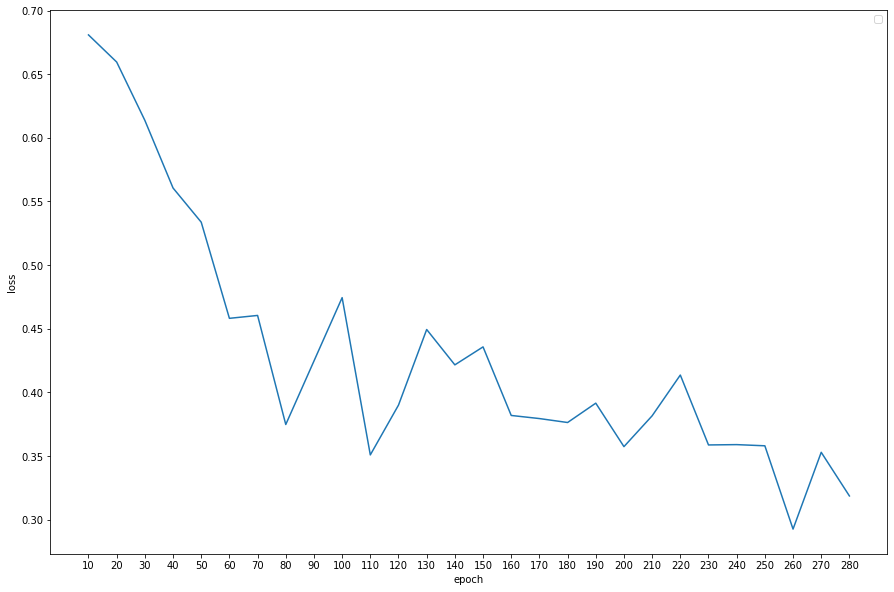

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,10))
ax.plot(loss_result)
ax.legend()
plt.xticks(ticks=range(len(loss_result)),labels=range(10,281,10))
plt.xlabel('epoch')
plt.ylabel('loss')

plt.show()